### Regularization Exercises


In [1]:
# Generate a set of random number
import numpy as np
import pandas as pd
from functools import partial
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
import sklearn.model_selection as skm
from ISLP import load_data
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression


### Question 1

In [2]:
# Preparing the Data

rng = np.random.default_rng(12345)
n = 100
generated = rng.normal(0,1,n)
noise = rng.normal(0,1,n)

power_range = np.arange(0,4)
beta = np.array([1,2,3,4])
vars = np.power.outer(generated, power_range)
response = vars @ beta + noise
power_range_data = np.arange(1,11)
data_gen = np.power.outer(generated, power_range_data)

data = pd.DataFrame(data_gen, columns=[f'X{i}' for i in power_range_data])
design = MS(data).fit(data)
x = design.transform(data)


In [3]:
def nCp(estimator, x, y, sigma) : 
    n,p = x.shape
    yhat = estimator.predict(x)
    rss = np.sum((y - yhat)**2)
    return -(rss + 2*p*sigma) / n

scale = sm.OLS(response, x).fit().scale
neg_nCp = partial(nCp, sigma=scale)
    

In [4]:
# Forward Strategy
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
forward_fit = sklearn_selected(sm.OLS, forward, scoring=neg_nCp)
forward_fit.fit(data, response)

# Backward Strategy
backward = Stepwise.first_peak(design, direction="backwards", max_terms=len(design.terms))
backward_fit = sklearn_selected(sm.OLS, backward, scoring=neg_nCp)
backward_fit.fit(data, response)

print(f"Forward Selection : {forward_fit.selected_state_}")
print(f"Backward Selection : {backward_fit.selected_state_}")

Forward Selection : ('X1', 'X2', 'X3')
Backward Selection : ('X1', 'X2', 'X3')


In [5]:
# Lasso Model
lambdas = np.logspace(-2, 2, 100)
cv = skm.ShuffleSplit(n_splits = 5, random_state=12345, test_size=0.2)
x_mean = x.mean()
x_std = x.std()
x_scaled = (x - x_mean) / x_std
x_scaled.dropna(axis=1, inplace=True)


In [6]:
# lasso implementation
lasso_mse = []
k = 5
for l in lambdas : 
    cv_results = 0
    for train_idx, test_idx in cv.split(x_scaled) : 
        x_train = x_scaled.iloc[train_idx]
        y_train = response[train_idx]
        x_test = x_scaled.iloc[test_idx]
        y_test = response[test_idx]
        lasso = skl.ElasticNet(alpha=l, l1_ratio=1)
        lasso.fit(x_train, y_train)
        yhat = lasso.predict(x_test)
        mse = np.mean((yhat - y_test)**2)
        cv_results += mse
    cv_results /= k
    lasso_mse.append(cv_results)
    cv_results = 0
    
lasso_mse = np.array(lasso_mse)
lasso_mse.shape
        

(100,)

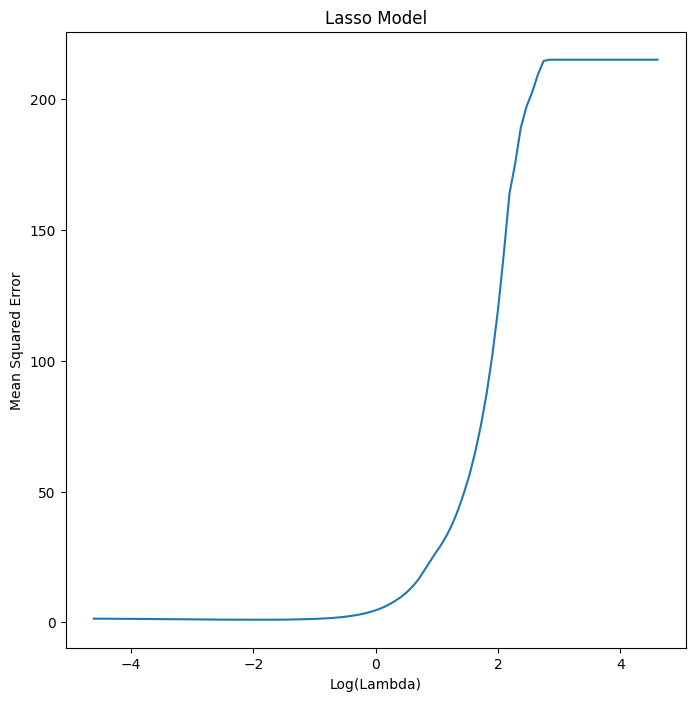

In [7]:
lasso_fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.log(lambdas), lasso_mse)
ax.set_xlabel("Log(Lambda)")
ax.set_ylabel("Mean Squared Error")
ax.set_title("Lasso Model")
plt.show()


In [8]:
# Lasso Model 
optimal_lambda = lambdas[np.argmin(lasso_mse)]
lasso = skl.ElasticNet(alpha=optimal_lambda, l1_ratio=1)
lasso.fit(x_scaled, response)
lasso_coef = lasso.coef_
lasso_coef, optimal_lambda # Selects the first 3 variables with high power and rest with 0.046 and low power

(array([ 1.6168942 ,  3.13496577, 11.26560395,  0.0460943 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 0.1484968262254465)

In [9]:
# Implementing the automated approach
scaler = StandardScaler(with_mean=True, with_std=True)
lassoCV = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas, cv=cv)
pipe = Pipeline([('scaler', scaler), ('lasso', lassoCV)])
pipe.fit(x,response)
pipe.named_steps['lasso'].coef_, pipe.named_steps['lasso'].alpha_

# Yay Similar Results

(array([ 0.        ,  1.60965797,  3.12013917, 11.20895357,  0.04573009,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]),
 0.1484968262254465)

In [10]:
beta = np.array([1,2])
response_new = np.power.outer(generated, np.array([0,7])) @ beta + noise

# Implementing Lasso
pipe.fit(x,response_new)
pipe.named_steps['lasso'].coef_, pipe.named_steps['lasso'].alpha_

# Forward Selection
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
forward_fit = sklearn_selected(sm.OLS, forward, scoring=neg_nCp)
forward_fit.fit(data, response_new)

# Backward Selection
backward = Stepwise.first_peak(design, direction="backwards", max_terms=len(design.terms))
backward_fit = sklearn_selected(sm.OLS, backward, scoring=neg_nCp)
backward_fit.fit(data, response_new)

print(f"Forward Selection : {forward_fit.selected_state_}")
print(f"Backward Selection : {backward_fit.selected_state_}")
print(f"Lasso : {pipe.named_steps['lasso'].coef_}")

# Woah Similar Results

Forward Selection : ('X5', 'X7', 'X9')
Backward Selection : ('X5', 'X7', 'X9')
Lasso : [  0.           1.67242508  -0.57043942 -18.20451232  -0.
  72.07503138   3.42405235  81.2018602    0.          47.34571737
   0.        ]


So forward, backward and lasso almost gets similar results, pretty close to the actual model. 

How did I implement : 
1. `Stepwise.first_peak()` : to define the strategy
2. `sklearn_selected()` : to implement the strategy
3. Standard For Loop with `cv.split()` to implement CV for lambda selection
4. `Scaler`, `skl.ElasticNetCV` and `Pipeline` to implement the lasso pipeline

What can be done more : 
1. `sklearn_selected_path()` : to get the path of the strategy
2. `skl.ElasticNetCV.path()` : to get the path of the strategy

Beware that the first two methods require ISLP's `ModelSpec` because they are implemented as a wrapper

#### Question 2

In [11]:
data = load_data("College")
data.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [12]:
design = MS(data.drop(columns="Apps"))
x = design.fit_transform(data)
y = data["Apps"]

In [13]:
cv = skm.ShuffleSplit(1, test_size=0.2, random_state=12345)

for train_idx, test_idx in cv.split(x) : 
    x_train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]
    x_test = x.iloc[test_idx]
    y_test = y.iloc[test_idx]
    model = sm.OLS(y_train, x_train).fit()
    yhat = model.predict(x_test)
    mse = np.mean((yhat - y_test)**2)
    print(f"MSE : {mse}")

MSE : 768308.325674253


In [35]:
lambdas = np.logspace(-2, 2, 100)
scaler = StandardScaler(with_mean=True, with_std=True)
cv = skm.ShuffleSplit(n_splits = 5, random_state=12345, test_size=0.2)
lassoCV = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas, cv=cv)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, cv=cv, l1_ratio=0)
pipeLasso = Pipeline([('scaler', scaler), ('lasso', lassoCV)])
pipeRidge = Pipeline([('scaler', scaler), ('ridge', ridgeCV)])
pipeLasso.fit(x,y)
pipeRidge.fit(x,y)

lasso_model = pipeLasso.named_steps['lasso']
ridge_model = pipeRidge.named_steps['ridge']

print(f"Lasso MSE : {np.min(-ridge_model.mse_path_.mean(axis=1))}")
print(f"Ridge MSE: {np.min(-ridge_model.mse_path_.mean(axis=1))}")
print(f"Lasso Coef : {lasso_model.coef_}")
print(f"Ridge Alpha : {ridge_model.alpha_}, Lasso Alpha : {lasso_model.alpha_}")

# Everything is there almost. 1 Non Zero Coeff

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4959527851.282621, tolerance: 1025984.5679304345
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 reg

Lasso MSE : -14174254.753122836
Ridge MSE: -14174254.753122836
Lasso Coef : [ 0.00000000e+00 -2.20095009e+02  3.88433002e+03 -8.17320625e+02
  8.80019520e+02 -2.81609559e+02  2.77868073e+02  6.76199134e+01
 -3.45177311e+02  1.65507646e+02  3.44253232e+00  2.10367628e+01
 -1.41592843e+02 -4.89933582e+01  6.08587027e+01  2.16598452e+00
  4.06480382e+02  1.48771508e+02]
Ridge Alpha : 0.01, Lasso Alpha : 0.01


/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.718e+08, tolerance: 1.162e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [31]:
# Thing is you don't need to have GridSearch to do this. 
# You can just do PCA(n_components = predictors) and then do a linear regression
# .explained_variance_ratio - will tell you how much variance is explained by each component

pca = PCA(n_components=18)
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(x,y)

var_exp = np.array(pipe.named_steps['pca'].explained_variance_ratio_)
comps = np.arange(1,19)
cum_var_exp = np.cumsum(var_exp)
var_exp


array([0.31669858, 0.25627714, 0.06997454, 0.05609877, 0.05482508,
       0.04988611, 0.0361328 , 0.03414762, 0.0309907 , 0.02401884,
       0.02104596, 0.01803162, 0.0109114 , 0.00848544, 0.00608774,
       0.00476065, 0.00162701, 0.        ])

In [22]:
# PLS Regression
pls = PLSRegression()
ncomps = np.arange(1, 18)
grid = {'pls__n_components': ncomps}
pipe = Pipeline([('scaler', scaler), ('pls', pls)])
grid_search = skm.GridSearchCV(pipe, grid, cv=cv)
grid_search.fit(x,y)
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('pls', PLSRegression(n_components=10))])

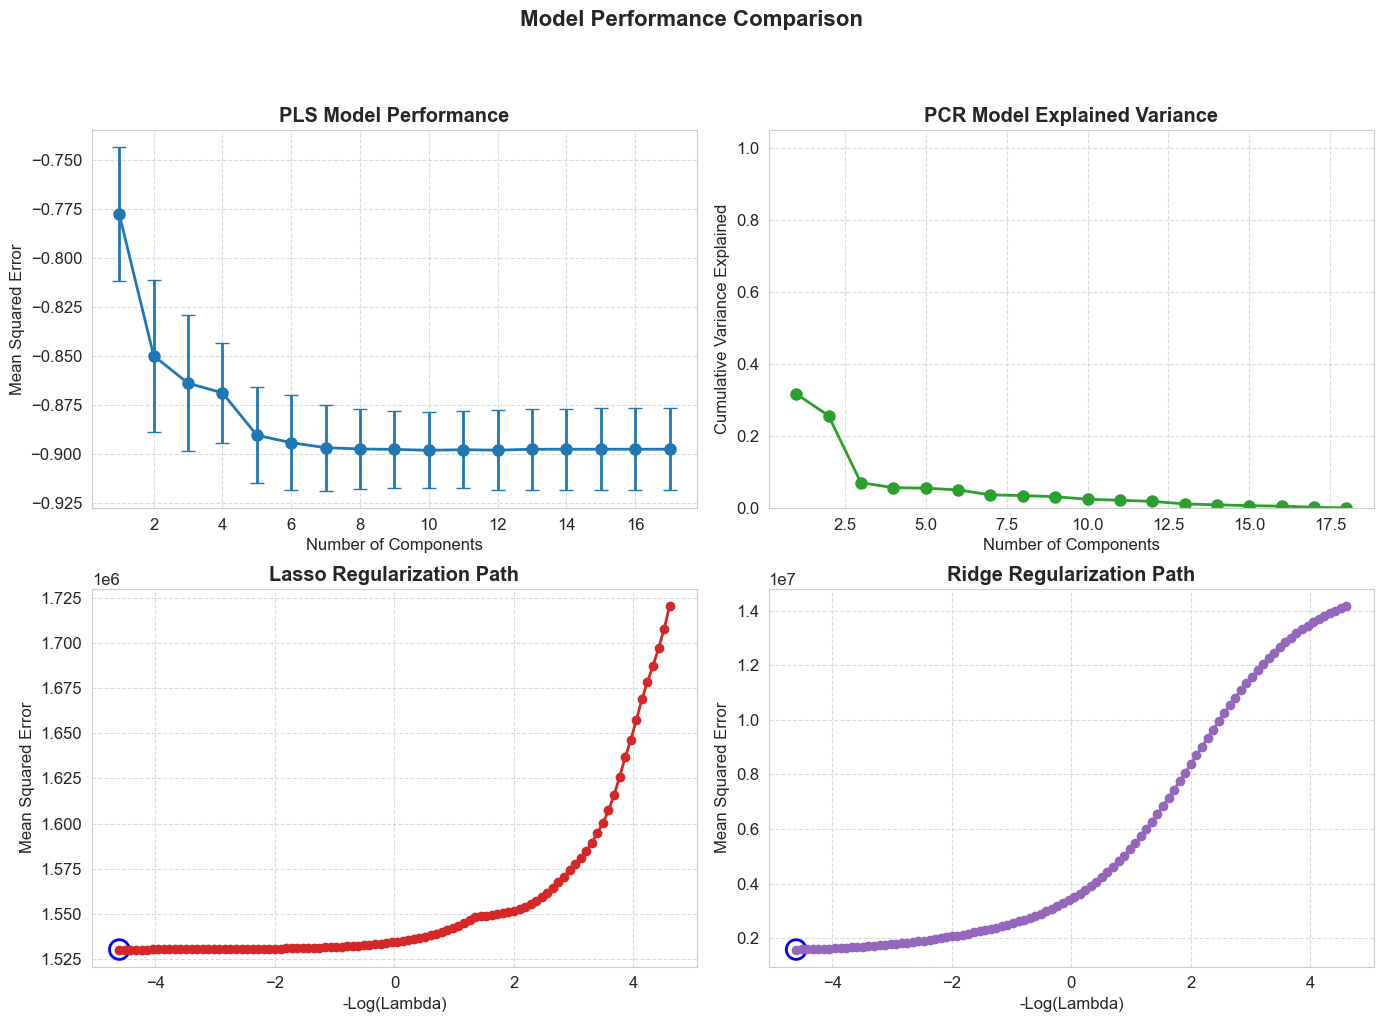

In [38]:
import seaborn as sns
# Set style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# 1. PLS Model
axes[0].errorbar(ncomps, -grid_search.cv_results_['mean_test_score'], 
                yerr=grid_search.cv_results_['std_test_score'],
                marker='o', markersize=8, capsize=5, elinewidth=2, linewidth=2)
axes[0].set_xlabel("Number of Components")
axes[0].set_ylabel("Mean Squared Error")
axes[0].set_title("PLS Model Performance", fontweight="bold")
axes[0].grid(True, linestyle='--', alpha=0.7)

# 2. PCR Model
axes[1].plot(comps, var_exp, 'o-', linewidth=2, color='#2ca02c', markersize=8)
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Variance Explained")
axes[1].set_title("PCR Model Explained Variance", fontweight="bold")
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_ylim([0, 1.05])

# 3. Lasso Model
lasso_line = axes[2].plot(-np.log(lambdas), lassoCV.mse_path_.mean(axis=1), 'o-', 
                         linewidth=2, color='#d62728', markersize=6)
axes[2].set_xlabel("-Log(Lambda)")
axes[2].set_ylabel("Mean Squared Error")
axes[2].set_title("Lasso Regularization Path", fontweight="bold")
axes[2].grid(True, linestyle='--', alpha=0.7)

# Add optimal lambda marker
best_lasso_idx = np.argmin(lassoCV.mse_path_.mean(axis=1))
axes[2].scatter(-np.log(lambdas[best_lasso_idx]), 
               lassoCV.mse_path_.mean(axis=1)[best_lasso_idx],
               s=200, facecolors='none', edgecolors='blue', linewidth=2)

# 4. Ridge Model
ridge_line = axes[3].plot(-np.log(lambdas), ridgeCV.mse_path_.mean(axis=1), 'o-', 
                         linewidth=2, color='#9467bd', markersize=6)
axes[3].set_xlabel("-Log(Lambda)")
axes[3].set_ylabel("Mean Squared Error")
axes[3].set_title("Ridge Regularization Path", fontweight="bold")
axes[3].grid(True, linestyle='--', alpha=0.7)

# Add optimal lambda marker
best_ridge_idx = np.argmin(ridgeCV.mse_path_.mean(axis=1))
axes[3].scatter(-np.log(lambdas[best_ridge_idx]), 
               ridgeCV.mse_path_.mean(axis=1)[best_ridge_idx],
               s=200, facecolors='none', edgecolors='blue', linewidth=2)

plt.tight_layout()
plt.suptitle("Model Performance Comparison", fontsize=16, fontweight="bold", y=1.02)
plt.subplots_adjust(top=0.9)
plt.show()

### Task :  Interpret the results of all the models fitted

You have only learned to fit the model and find the best model, interpret the model now - make some inference

In [57]:
# From Graphs
lasso_alpha = 0.1
ridge_alpha = 0.1 
pls_comp = 8
pca_comp = 10

In [42]:
# Preparing the data for final evaluation
data = load_data("College")
data = data.dropna()
x = MS(data.drop(columns="Apps")).fit_transform(data)
y = data["Apps"]

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.270e+08, tolerance: 9.754e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.303e+08, tolerance: 8.330e+05 Linear regression models with null wei

            Mean MSE       Std MSE
Linear  1.495303e+06  6.001687e+05
Lasso   1.495704e+06  6.009483e+05
PLS     1.511829e+06  6.401874e+05
Ridge   2.078587e+06  1.393634e+06
PCR     2.711339e+06  1.733480e+06


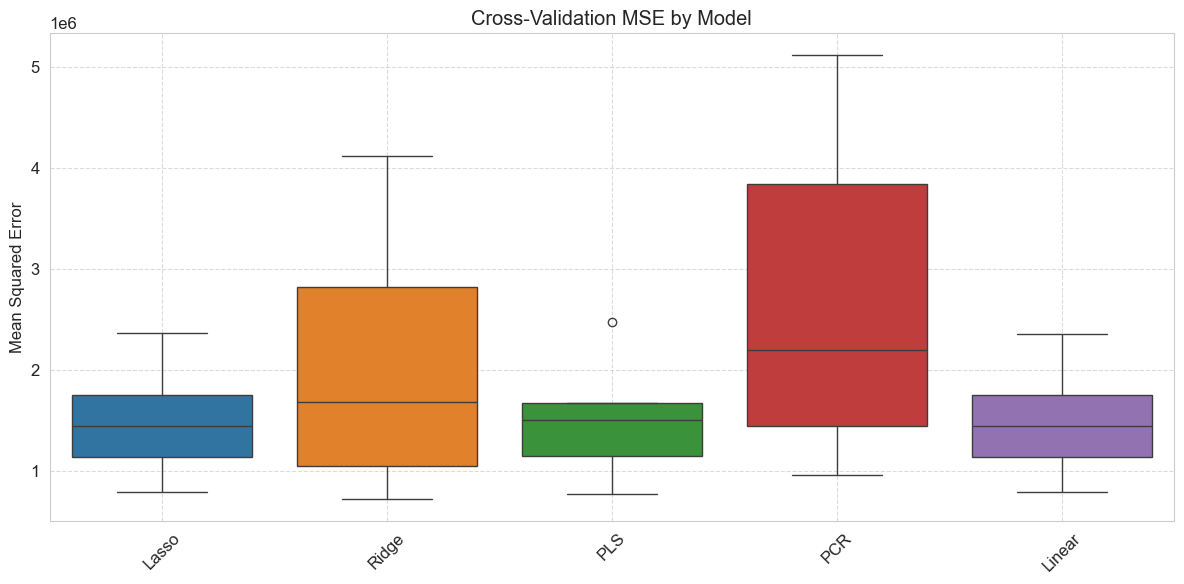

In [59]:
def evaluate_models(x, y, random_state=12345, cv_splits=5):
    # Define models
    models = {
        'Lasso': skl.ElasticNet(alpha=lasso_alpha, l1_ratio=1),
        'Ridge': skl.ElasticNet(alpha=ridge_alpha, l1_ratio=0),
        'PLS': PLSRegression(n_components=pls_comp),
        'PCR': Pipeline([("pca", PCA(n_components=pca_comp)), ("linear", skl.LinearRegression())]),
        "Linear" : skl.LinearRegression()
    }
    
    # Create cross-validation splits
    cv = skm.ShuffleSplit(n_splits=cv_splits, test_size=0.3, random_state=random_state)
    
    # Store results
    results = {model_name: [] for model_name in models.keys()}
    
    # Evaluate each model on each CV split
    for train_idx, test_idx in cv.split(x):
        x_train = x[train_idx]
        y_train = y[train_idx]
        x_test = x[test_idx]
        y_test = y[test_idx]
        
        # Fit and evaluate each model
        for name, model in models.items():
            model.fit(x_train, y_train)
            yhat = model.predict(x_test)
            mse = np.mean((yhat - y_test)**2)
            results[name].append(mse)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate summary statistics
    summary = pd.DataFrame({
        'Mean MSE': results_df.mean(),
        'Std MSE': results_df.std()
    }).sort_values('Mean MSE')
    
    return summary, results_df

# Run evaluation
summary, cv_results = evaluate_models(x, y)
print(summary)

# Optional: Visualize results
plt.figure(figsize=(12, 6))
sns.boxplot(data=cv_results)
plt.title('Cross-Validation MSE by Model')
plt.ylabel('Mean Squared Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Comparing in terms of `MSE`
1. Lasso & PLS seems to perform well with the lowest MSE, notably Lasso has a lower variance. 
2. Ridge has a MSE and higher variance as well. 
3. PCR has the highest variance - which was expected because we took around 10 components

In general we can expect Lasso to perform good model selection by shrinking the coefficients to zero. Ridge on the other hand needs to be evaluated more. 
PLS peforms better than PCR in terms of reducing the components. 

Note we used `ElasticCV()` and `GridSearchCV()` to find the best components i.e. best hyperparameters in lasso, ridge, PLS & PCR

### Question 3

Purpose : With parameter increase, the training MSE will decrease but testing won't

In [85]:
# Defining the Data
rng = np.random.default_rng(12345)
n = 1000
p = 20
x = rng.normal(0, 1, (n, p))
beta = rng.normal(0,1,p)
zero_indices = rng.choice(p, size=4, replace=False)
beta[zero_indices] = 0

response = x @ beta + rng.normal(0, 1, n)
x_data = pd.DataFrame(x, columns=[f'X{i}' for i in range(p)])
design = MS(x_data).fit(x_data)
x = design.transform(x_data)

In [87]:
# Splitting the data
cv = skm.ShuffleSplit(1, test_size=0.1, random_state=12345)
train_idx, test_idx = next(cv.split(x))

x_train = x.iloc[train_idx]
y_train = response[train_idx]
x_test = x.iloc[test_idx]
y_test = response[test_idx]


In [133]:
# Best Subset Selection
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
forward_fit = sklearn_selection_path(sm.OLS, forward)
forward_fit.fit(x_train, y_train)
predict_test = forward_fit.predict(x_test)
predict_train = forward_fit.predict(x_train)
y_train = np.array(y_train).reshape(-1,1)
y_test_data = np.array(y_test).reshape(-1,1)
mse_test = ((predict_test - y_test_data)**2).mean(0)
mse_train = ((predict_train - y_train)**2).mean(0)

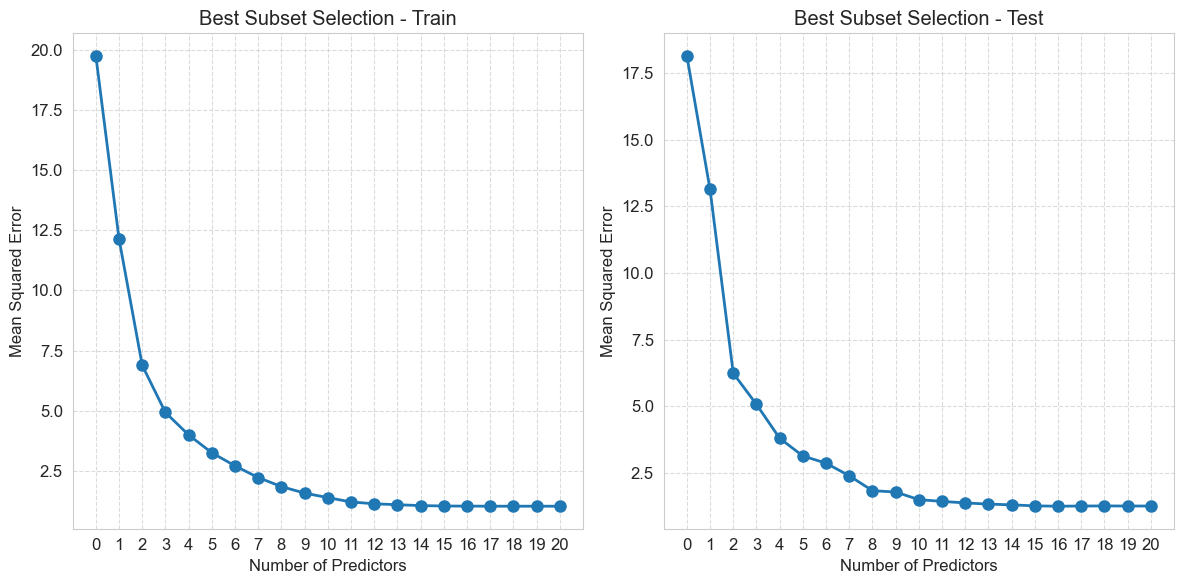

In [135]:
predictors = np.arange(0,21)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(predictors, mse_train, marker='o', markersize=8, linewidth=2)
ax[0].set_xlabel("Number of Predictors")
ax[0].set_ylabel("Mean Squared Error")
ax[0].set_title("Best Subset Selection - Train")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].set_xticks(predictors)

ax[1].plot(predictors, mse_test, marker='o', markersize=8, linewidth=2)
ax[1].set_xlabel("Number of Predictors")
ax[1].set_ylabel("Mean Squared Error")
ax[1].set_title("Best Subset Selection - Test")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].set_xticks(predictors)
plt.tight_layout()
plt.show()

In [187]:
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
forward_fit = sklearn_selected(sm.OLS, forward)
forward_fit.fit(x_train, y_train)
forward_fit.selected_state_

('X0', 'X1', 'X10', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9')

Okay they are selecting models till X10 -> which is good in terms of MSE

In [188]:
# 10 Predictors
design = MS(x_data.drop(columns=[f'X{i}' for i in range(11,20)]))
x = design.fit_transform(x_data)
coef = sm.OLS(response,x).fit().params
coef_mod = coef.iloc[1:]
coef_zero = np.zeros(20)
coef_zero[np.arange(0,len(coef_mod))] = coef_mod

diff = ((coef_zero - beta)**2)**0.5
beta.shape, coef_zero.shape

((20,), (20,))

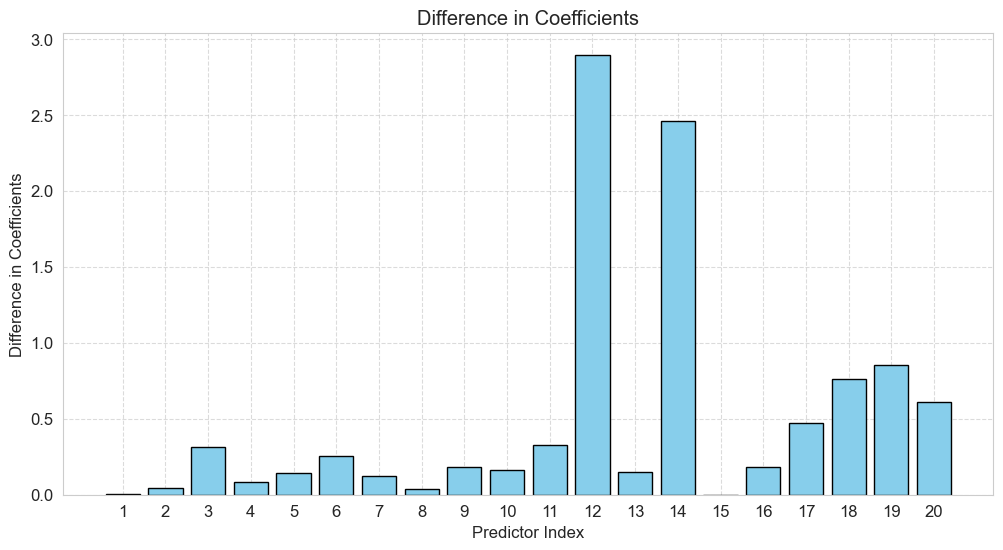

In [189]:
# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(np.arange(1,21), diff, color='skyblue', edgecolor='black', linewidth=1)
ax.set_xlabel("Predictor Index")
ax.set_ylabel("Difference in Coefficients")
ax.set_title("Difference in Coefficients")
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xticks(np.arange(1,21))
plt.show()

The coefficient difference for the best model till the included parameters are almost close to 0, but post that it shoots up - probably i need to normalize it then. 

#### Question 3

Goal : Predict `PerCapitaCrime` in the `Boston` Dataset

In [194]:
data = load_data("Boston")
data.shape # 506 with 13 Predictors

(506, 13)

In [196]:
data.head() # We are going to use crim

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [198]:
design = MS(data.drop(columns="crim"))
x = design.fit_transform(data)
y = data["crim"]

In [236]:
lambdas = np.logspace(-2, 2, 100)
scaler = StandardScaler(with_mean=True, with_std=True)
cv = skm.ShuffleSplit(n_splits = 5, random_state=12345, test_size=0.2)
lassoCV = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas, cv=cv)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, cv=cv, l1_ratio=0)
pipeLasso = Pipeline([('scaler', scaler), ('lasso', lassoCV)])
pipeRidge = Pipeline([('scaler', scaler), ('ridge', ridgeCV)])
pipeLasso.fit(x,y)
pipeRidge.fit(x,y)
lasso_model = pipeLasso.named_steps['lasso']
ridge_model = pipeRidge.named_steps['ridge']

/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16147.061520463501, tolerance: 3.2899055278762392
  model = cd_fast.enet_coordinate_descent_gram(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 re

In [237]:
print(f"Lasso Alpha : {lasso_model.alpha_}, Ridge Alpha : {ridge_model.alpha_}")
print(f"Lasso Coef : {lasso_model.coef_}")
print(f"Ridge Coef : {ridge_model.coef_}")
print(f"Lasso MSE : {np.min(-lasso_model.mse_path_.mean(axis=1))}")
print(f"Ridge MSE : {np.min(-ridge_model.mse_path_.mean(axis=1))}")

Lasso Alpha : 0.6579332246575682, Ridge Alpha : 0.13530477745798075
Lasso Coef : [ 0.          0.          0.         -0.          0.         -0.
  0.         -0.0055875   4.0921929   0.          0.          0.94725489
 -0.41694508]
Ridge Coef : [ 0.          0.65091902 -0.42416779 -0.21734015 -0.25358649  0.28781696
  0.05276657 -1.16039102  3.19783392  1.01107759 -0.18123555  1.08883824
 -1.17303433]
Lasso MSE : -42.73761049146037
Ridge MSE : -40.40045607709178


In [214]:
# PCR & PLS
pca = PCA(n_components=13)
pipePCA = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', skl.LinearRegression())])
pipePCA.fit(x,y)
var_exp = np.array(pipePCA.named_steps['pca'].explained_variance_ratio_)
cum_var_exp = np.cumsum(var_exp)

# PLS
ncomps = np.arange(1, 13)
pls = PLSRegression()
grid = {'pls__n_components': ncomps}
pipePLS = Pipeline([('scaler', scaler), ('pls', pls)])
grid_search = skm.GridSearchCV(pipePLS, grid, cv=cv)
grid_search.fit(x,y)
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('pls', PLSRegression(n_components=3))])

In [220]:
print(f"PCA Explained Variance : {cum_var_exp}")   
print(f"PLS Best Components : {grid_search.best_estimator_}")

PCA Explained Variance : [0.49927632 0.63642972 0.72941234 0.80212739 0.86832366 0.90255995
 0.92791269 0.9498778  0.96783351 0.98328972 0.99481073 1.
 1.        ]
PLS Best Components : Pipeline(steps=[('scaler', StandardScaler()),
                ('pls', PLSRegression(n_components=3))])


/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.766e+03, tolerance: 3.145e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/krishuagarwal/Desktop/Programming/python/dataScience/datasci-env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.408e+03, tolerance: 3.184e+00 Linear regression models with null wei

         Mean MSE    Std MSE
Ridge   25.992555  15.127155
Lasso   25.993485  15.692285
PLS     26.477969  15.287884
Linear  26.490448  14.650214
PCA     27.005318  16.094824


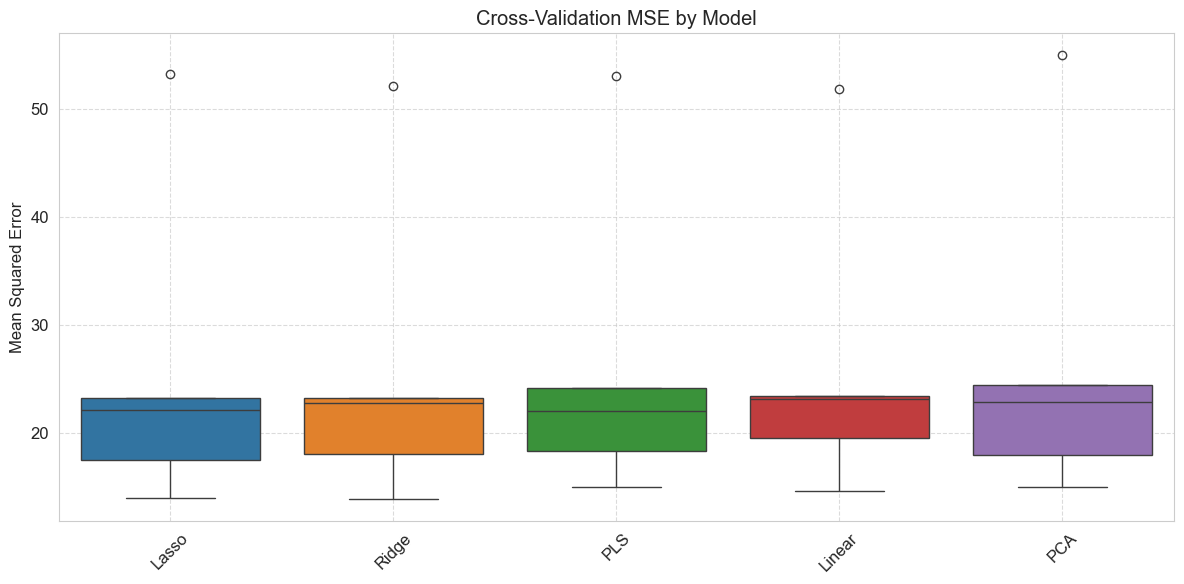

In [253]:
models = {
    'Lasso': skl.ElasticNet(alpha=lasso_model.alpha_, l1_ratio=1),
    'Ridge': skl.ElasticNet(alpha=ridge_model.alpha_, l1_ratio=0),
    'PLS': PLSRegression(n_components=3),
    'Linear' : skl.LinearRegression(),
    "PCA" : Pipeline([('scaler', scaler), ('pca', PCA(n_components=9)), ('linreg', skl.LinearRegression())])
}

cv = skm.ShuffleSplit(n_splits=5, test_size=0.3, random_state=12345)
results = {model_name: [] for model_name in models.keys()}
for train_idx, test_idx in cv.split(x):
    x_train = x.iloc[train_idx]
    y_train = y.iloc[train_idx]
    x_test = x.iloc[test_idx]
    y_test = y.iloc[test_idx]
    
    for name, model in models.items():
        model.fit(x_train, y_train)
        yhat = model.predict(x_test)
        mse = np.mean((yhat - y_test)**2)
        results[name].append(mse)
        
results_df = pd.DataFrame(results)
summary = pd.DataFrame({
    'Mean MSE': results_df.mean(),
    'Std MSE': results_df.std()
}).sort_values('Mean MSE')
print(summary)

# Optional: Visualize results
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df)
plt.title('Cross-Validation MSE by Model')
plt.ylabel('Mean Squared Error')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [242]:
# Lasso Performs the best in predicting while selecting the variables which matters the most
# Ridge is the second best
# PLS is the third best
# Point is Linear regression is somewhere around lasso but it is including every variable and hence it is not as good as Lasso
lasso_model.coef_ , x.columns[lasso_model.coef_ != 0] # Lasso selects 3 variables

(array([ 0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        -0.        ,  0.        , -0.0055875 ,  4.0921929 ,  0.        ,
         0.        ,  0.94725489, -0.41694508]),
 Index(['dis', 'rad', 'lstat', 'medv'], dtype='object'))

In [247]:
forward = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))
forward_fit = sklearn_selected(sm.OLS, forward)
forward_fit.fit(x,y)
forward_fit.selected_state_, x.columns[ridge_model.coef_ != 0]

# Forward Selection & Ridge Almost same

(('age',
  'chas',
  'dis',
  'indus',
  'lstat',
  'medv',
  'nox',
  'ptratio',
  'rad',
  'rm',
  'tax',
  'zn'),
 Index(['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
        'ptratio', 'lstat', 'medv'],
       dtype='object'))

Lasso is selecting three variables and still able to match the test prediction quite well to ridge and forward selection well - Quite Intuitive.

Interestingly PartialLeastSqare is almost selecting 3 components - same as lasso

Tasks : 
- Need to learn more about
  - `PrincipalComponentsRegression()`
  - `PartialLeastSqaureRegression()`